In [1]:
# Import necessary libraries
import torch  # Core PyTorch library for tensor operations
import torch.nn as nn  # PyTorch module for building neural networks
import torch.optim as optim  # Optimizers like Adam, SGD, etc.
from torch.utils.data import DataLoader, TensorDataset  # For batching and loading data
import numpy as np  # For array operations
import matplotlib.pyplot as plt  # For plotting images and graphs
import pickle  # For loading CIFAR-10 data in binary format
from pytorch_msssim import ssim  # SSIM loss function for image similarity


In [2]:
# Function to load pickled CIFAR-10 data file
def unpickle(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')  # Load with correct encoding
    return batch

# Load one batch of CIFAR-10 dataset
batch = unpickle('data_batch_1')
data = batch[b'data']  # Image pixel data (in bytes)
labels = batch[b'labels']  # Corresponding labels

# Normalize and reshape image data to [-1, 1] range, and shape (N, 3, 32, 32)
images = data.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
images = (images * 2.0) - 1.0  # Normalize from [0,1] to [-1,1]
images = torch.tensor(images[:10000])  # Use only first 10,000 images
labels = labels[:10000]  # Matching labels

# Wrap data and labels into a dataset and dataloader for batching
dataset = TensorDataset(images, torch.tensor(labels))
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)  # Shuffle and batch


In [3]:
# Define a lightweight convolutional autoencoder as in the chosen video
class LightAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # Downsample 32x32 -> 16x16
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # 4x4 -> 8x8
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),  # 16x16 -> 32x32
            nn.Tanh()  # Output in [-1, 1]
        )

    # Forward pass: encode then decode
    def forward(self, x):
        return self.decoder(self.encoder(x))


In [4]:
# Set device to CPU as this is what this github repository uses (can change to "cuda" if GPU available)
device = torch.device("cpu")
model = LightAutoencoder().to(device)  # Move model to device

# Define combined loss: MSE + weighted SSIM
def combined_loss(output, target):
    mse = nn.functional.mse_loss(output, target)  # Pixel-wise loss
    ssim_loss = 1 - ssim(output, target, data_range=2.0, size_average=True)  # Structural loss
    return mse + 0.5 * ssim_loss  # Weighted combination

# Setup Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop config
num_epochs = 50
losses = []  # Track loss per epoch

# Train the autoencoder
print("Training autoencoder...")
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_data, _ in dataloader:
        batch_data = batch_data.to(device)
        optimizer.zero_grad()  # Clear previous gradients
        output = model(batch_data)  # Forward pass
        loss = combined_loss(output, batch_data)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        epoch_loss += loss.item()  # Accumulate loss
    avg_loss = epoch_loss / len(dataloader)  # Average epoch loss
    losses.append(avg_loss)
    if (epoch + 1) % 5 == 0:  # Print every 5 epochs
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")
print("Training complete!")


Training autoencoder...
Epoch 5/50, Loss: 0.151536
Epoch 10/50, Loss: 0.113886
Epoch 15/50, Loss: 0.090334
Epoch 20/50, Loss: 0.079141
Epoch 25/50, Loss: 0.073173
Epoch 30/50, Loss: 0.067964
Epoch 35/50, Loss: 0.069208
Epoch 40/50, Loss: 0.060841
Epoch 45/50, Loss: 0.057584
Epoch 50/50, Loss: 0.054619
Training complete!


In [5]:
# Convert text to binary bits with a 32-bit header representing message length
def text_to_bits_with_header(text):
    msg_bytes = text.encode('utf-8')
    msg_len = len(msg_bytes)
    header_bits = [int(bit) for bit in format(msg_len, '032b')]  # Length header
    message_bits = [int(bit) for byte in msg_bytes for bit in format(byte, '08b')]  # Message bits
    return header_bits + message_bits

# Convert bits (with header) back to string
def bits_to_text_with_header(bits):
    header = bits[:32]
    msg_len = int(''.join(str(bit) for bit in header), 2)  # Extract message length
    message_bits = bits[32:32 + msg_len * 8]  # Extract actual message
    chars = [int(''.join(str(bit) for bit in message_bits[i:i+8]), 2)
             for i in range(0, len(message_bits), 8)]
    return bytes(chars).decode('utf-8', errors='ignore')  # Convert to string

# Embed bits into LSB of image tensor
def embed_message_in_image_tensor(tensor_img, bits):
    img_np = ((tensor_img.numpy() + 1.0) * 127.5).astype(np.uint8)  # Scale to [0,255]
    flat_img = img_np.flatten()
    if len(bits) > len(flat_img):
        raise ValueError("Message too long for this image.")
    for i, bit in enumerate(bits):
        flat_img[i] = (flat_img[i] & 0xFE) | bit  # Set LSB to bit
    img_np_stego = flat_img.reshape(img_np.shape)
    stego_tensor = torch.tensor(img_np_stego, dtype=torch.float32) / 127.5 - 1.0  # Rescale to [-1,1]
    return stego_tensor

# Extract bits from LSB of image tensor
def extract_bits_from_image_tensor(tensor_img, num_bits):
    img_np = ((tensor_img.numpy() + 1.0) * 127.5).astype(np.uint8)
    flat_img = img_np.flatten()
    bits = [int(pixel & 1) for pixel in flat_img[:num_bits]]  # Extract LSB
    return bits

# Convert tensor to displayable image
def tensor_to_image(t):
    return np.clip(((t.permute(1, 2, 0).numpy()) + 1.0) / 2.0, 0, 1)  # Convert from [-1,1] to [0,1]


In [6]:
# The secret message to hide
message = "Hello World!"
bits = text_to_bits_with_header(message)  # Convert message to bits with header

# Select an image and clone it to avoid modifying original
original_tensor = images[0].clone()  # Shape: (3,32,32), values in [-1,1]

# Embed message into image
stego_tensor = embed_message_in_image_tensor(original_tensor, bits)

# Run stego image through autoencoder
model.eval()
with torch.no_grad():
    reconstructed_tensor = model(stego_tensor.unsqueeze(0)).squeeze(0)  # Shape: (3,32,32)

# Extract bits from autoencoder's output image
extracted_bits = extract_bits_from_image_tensor(reconstructed_tensor.cpu(), num_bits=len(bits))

# Convert extracted bits back to text
extracted_message = bits_to_text_with_header(extracted_bits)

# Display results
print(f"Original message: '{message}'")
print(f"Extracted message: '{extracted_message}'")


Original message: 'Hello World!'
Extracted message: 'NZOdt(jh['


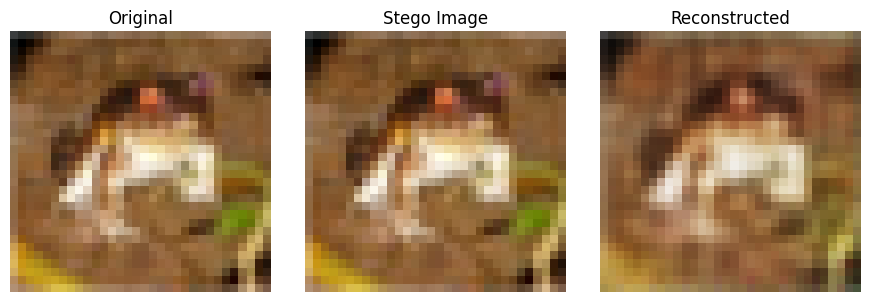

In [7]:
# Plot original, stego, and reconstructed images
plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.imshow(tensor_to_image(original_tensor))
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(tensor_to_image(stego_tensor))
plt.title('Stego Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(tensor_to_image(reconstructed_tensor.cpu()))
plt.title('Reconstructed')
plt.axis('off')

plt.tight_layout()
plt.show()


In [9]:
# Non-matching bits due to an innefective approach 
bits = text_to_bits_with_header(message)
stego_tensor = embed_message_in_image_tensor(original_tensor, bits)

img_np = ((stego_tensor.numpy() + 1.0) * 127.5).astype(np.uint8)
flat_img = img_np.flatten()

print("First 32 bits in image LSBs:", [pixel & 1 for pixel in flat_img[:32]])
print("Header bits you expected:", bits[:32])


First 32 bits in image LSBs: [np.uint8(1), np.uint8(1), np.uint8(1), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(1), np.uint8(1), np.uint8(0), np.uint8(0)]
Header bits you expected: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]


Original message: 'Hello World!'
Extracted message: 'Hello World!'


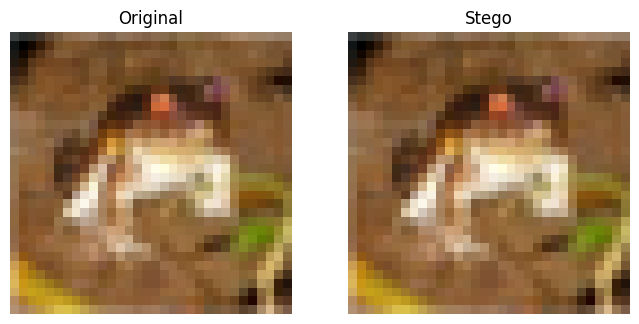

In [10]:
# LSB approach (realization pytorch is not the most optimal approach)
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

batch = unpickle('data_batch_1')
data = batch[b'data']
labels = batch[b'labels']

images = data.reshape(-1, 3, 32, 32).astype(np.uint8)  # Keep as uint8 here
images = torch.tensor(images[:10000])  # Use first 10k

def text_to_bits_with_header(text):
    msg_bytes = text.encode('utf-8')
    msg_len = len(msg_bytes)
    header_bits = [int(bit) for bit in format(msg_len, '032b')]  # 32 bit header
    message_bits = [int(bit) for byte in msg_bytes for bit in format(byte, '08b')]
    return header_bits + message_bits

def bits_to_text_with_header(bits):
    header_bits = bits[:32]
    msg_len = int(''.join(str(bit) for bit in header_bits), 2)
    message_bits = bits[32:32 + msg_len * 8]
    chars = []
    for i in range(0, len(message_bits), 8):
        byte_bits = message_bits[i:i+8]
        if len(byte_bits) < 8:
            break
        chars.append(int(''.join(str(bit) for bit in byte_bits), 2))
    return bytes(chars).decode('utf-8', errors='ignore')

def embed_message_in_image(img_np, bits):
    """
    img_np: numpy uint8 array shape (3,32,32)
    bits: list of 0/1 bits
    """
    flat_img = img_np.flatten()
    if len(bits) > len(flat_img):
        raise ValueError("Message too long to embed in image!")

    # Clear LSB then set
    flat_img[:len(bits)] = (flat_img[:len(bits)] & 0xFE) | bits
    return flat_img.reshape(img_np.shape)

def extract_bits_from_image(img_np, num_bits):
    flat_img = img_np.flatten()
    bits = flat_img[:num_bits] & 1
    return bits.tolist()

message = "Hello World!"
bits = text_to_bits_with_header(message)

original_img_np = images[0].numpy()  # uint8 (3,32,32)
stego_img_np = embed_message_in_image(original_img_np.copy(), bits)
extracted_bits = extract_bits_from_image(stego_img_np, len(bits))
extracted_message = bits_to_text_with_header(extracted_bits)

print(f"Original message: '{message}'")
print(f"Extracted message: '{extracted_message}'")

# Visualize original and stego
def np_to_img(np_img):
    # (3,32,32) uint8 -> (32,32,3) float [0,1]
    return np.transpose(np_img, (1, 2, 0)) / 255.0

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(np_to_img(original_img_np))
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(np_to_img(stego_img_np))
plt.title("Stego")
plt.axis('off')

plt.show()
